<a href="https://colab.research.google.com/github/Aditya01237/Machine_Learning_2/blob/main/smoker_status_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# 1. SETUP AND IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"Random seed set to: {RANDOM_SEED}")

Libraries imported successfully!
Random seed set to: 42


In [4]:
import kagglehub

# ============================================================================
# 1. DATA IMPORT
# ============================================================================

path = kagglehub.dataset_download("gauravduttakiit/smoker-status-prediction-using-biosignals")
print("Path to dataset files:", path)

csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

if csv_files:
    full_file_path = os.path.join(path, csv_files[0])
    print(f"Loading file: {csv_files[0]}")

    df = pd.read_csv(full_file_path)

    print("\n" + "="*80)
    print("DATASET OVERVIEW")
    print("="*80)
    print(f"\nDataset Shape: {df.shape}")
    print(f"Number of samples: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")

    print("\nFirst few rows:")
    print(df.head())

    print("\nDataset Info:")
    print(df.info())

    print("\nBasic Statistics:")
    print(df.describe())

else:
    print("Error: No CSV file found in the downloaded directory.")

Using Colab cache for faster access to the 'smoker-status-prediction-using-biosignals' dataset.
Path to dataset files: /kaggle/input/smoker-status-prediction-using-biosignals
Loading file: train_dataset.csv

DATASET OVERVIEW

Dataset Shape: (38984, 23)
Number of samples: 38984
Number of features: 23

First few rows:
   age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  \
0   35         170          85       97.0             0.9              0.9   
1   20         175         110      110.0             0.7              0.9   
2   45         155          65       86.0             0.9              0.9   
3   45         165          80       94.0             0.8              0.7   
4   20         165          60       81.0             1.5              0.1   

   hearing(left)  hearing(right)  systolic  relaxation  ...  HDL  LDL  \
0              1               1       118          78  ...   70  142   
1              1               1       119          79  ...   71  1


EXPLORATORY DATA ANALYSIS

Missing Values:
No missing values found!

Target Variable Distribution:
smoking
0    24666
1    14318
Name: count, dtype: int64

Target Variable Proportions:
smoking
0    0.632721
1    0.367279
Name: proportion, dtype: float64


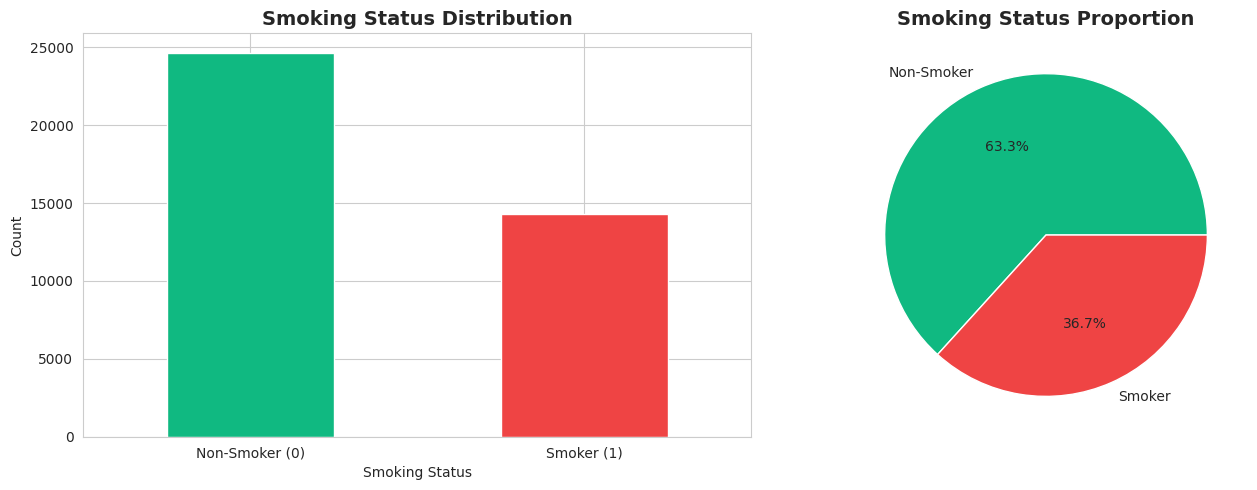

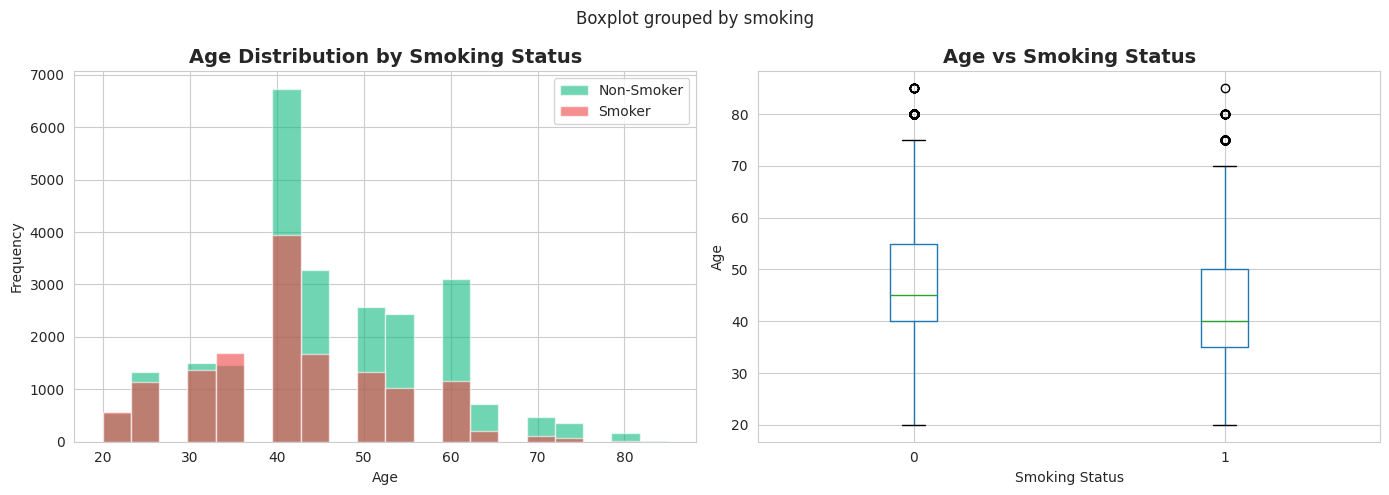


Generating Correlation Matrix...


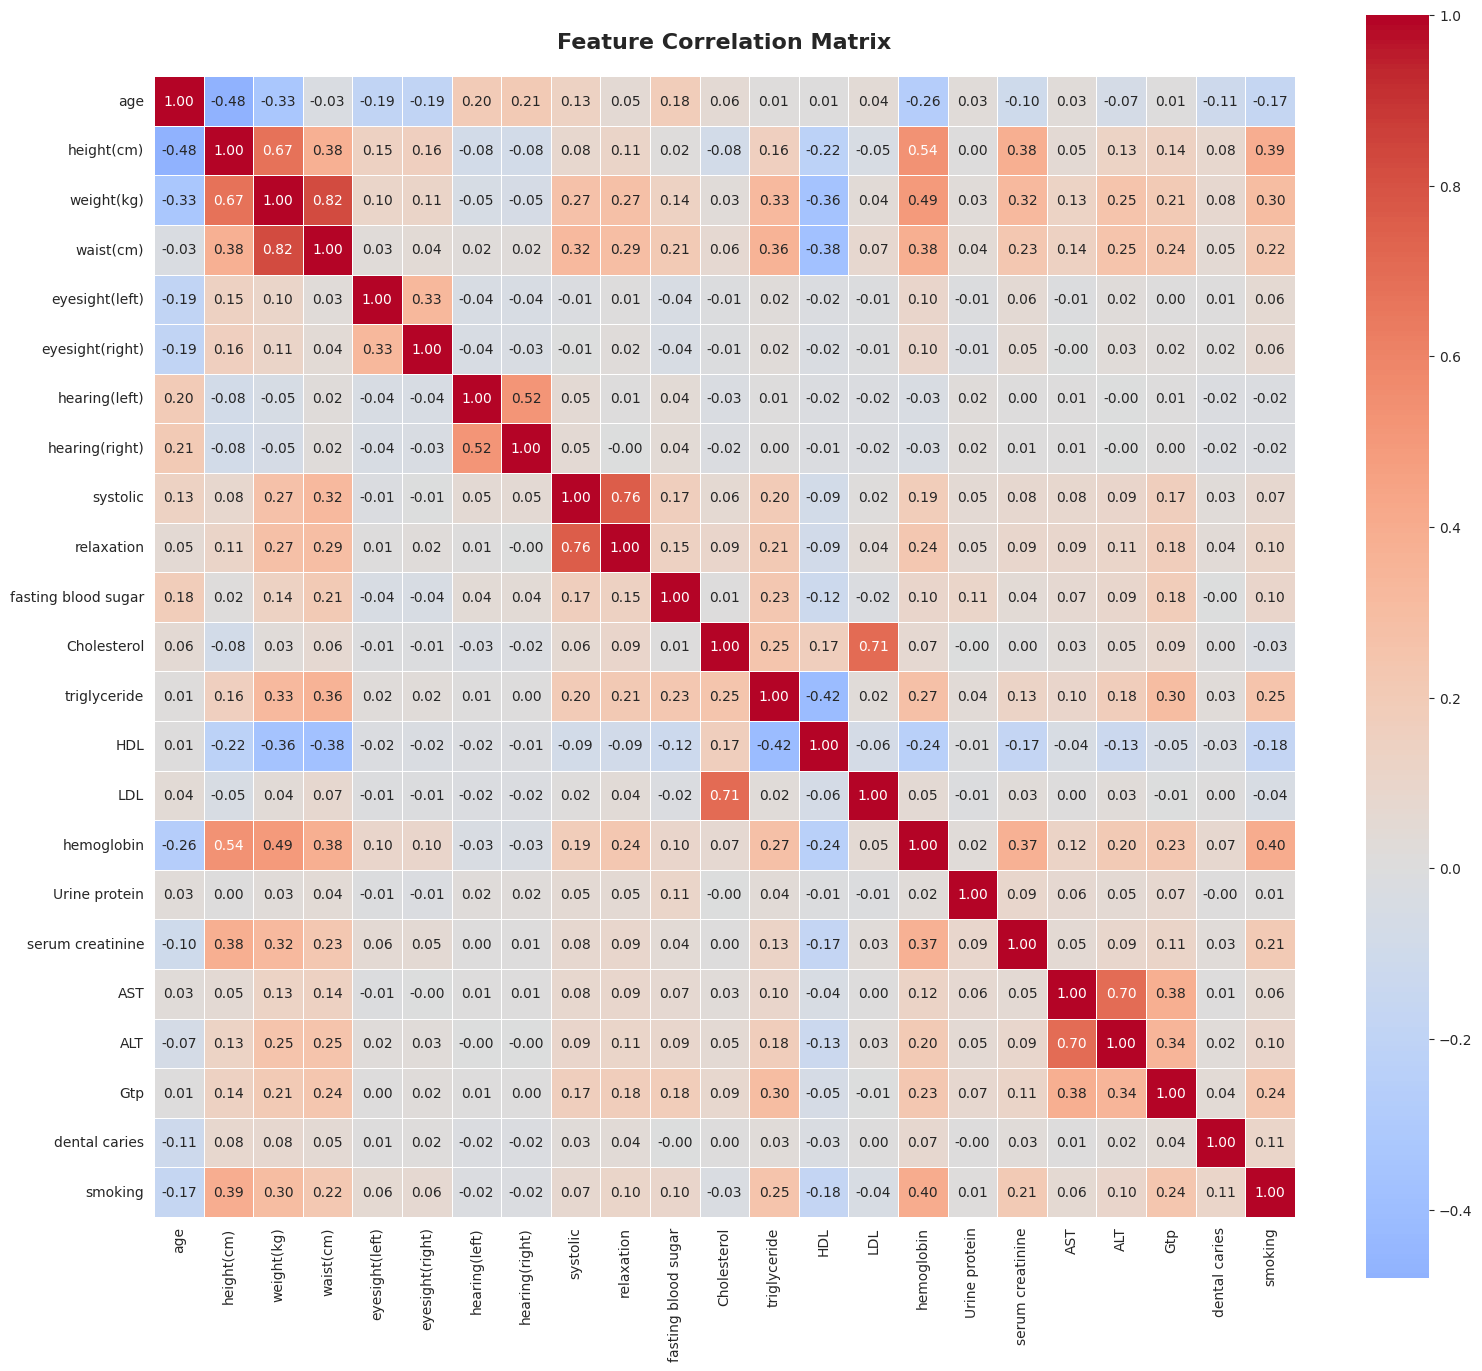


Top 10 Features Correlated with Smoking:
smoking                1.000000
hemoglobin             0.401206
height(cm)             0.394314
weight(kg)             0.299347
triglyceride           0.251057
Gtp                    0.240274
waist(cm)              0.223359
serum creatinine       0.212473
dental caries          0.107601
relaxation             0.103663
fasting blood sugar    0.099908
Name: smoking, dtype: float64


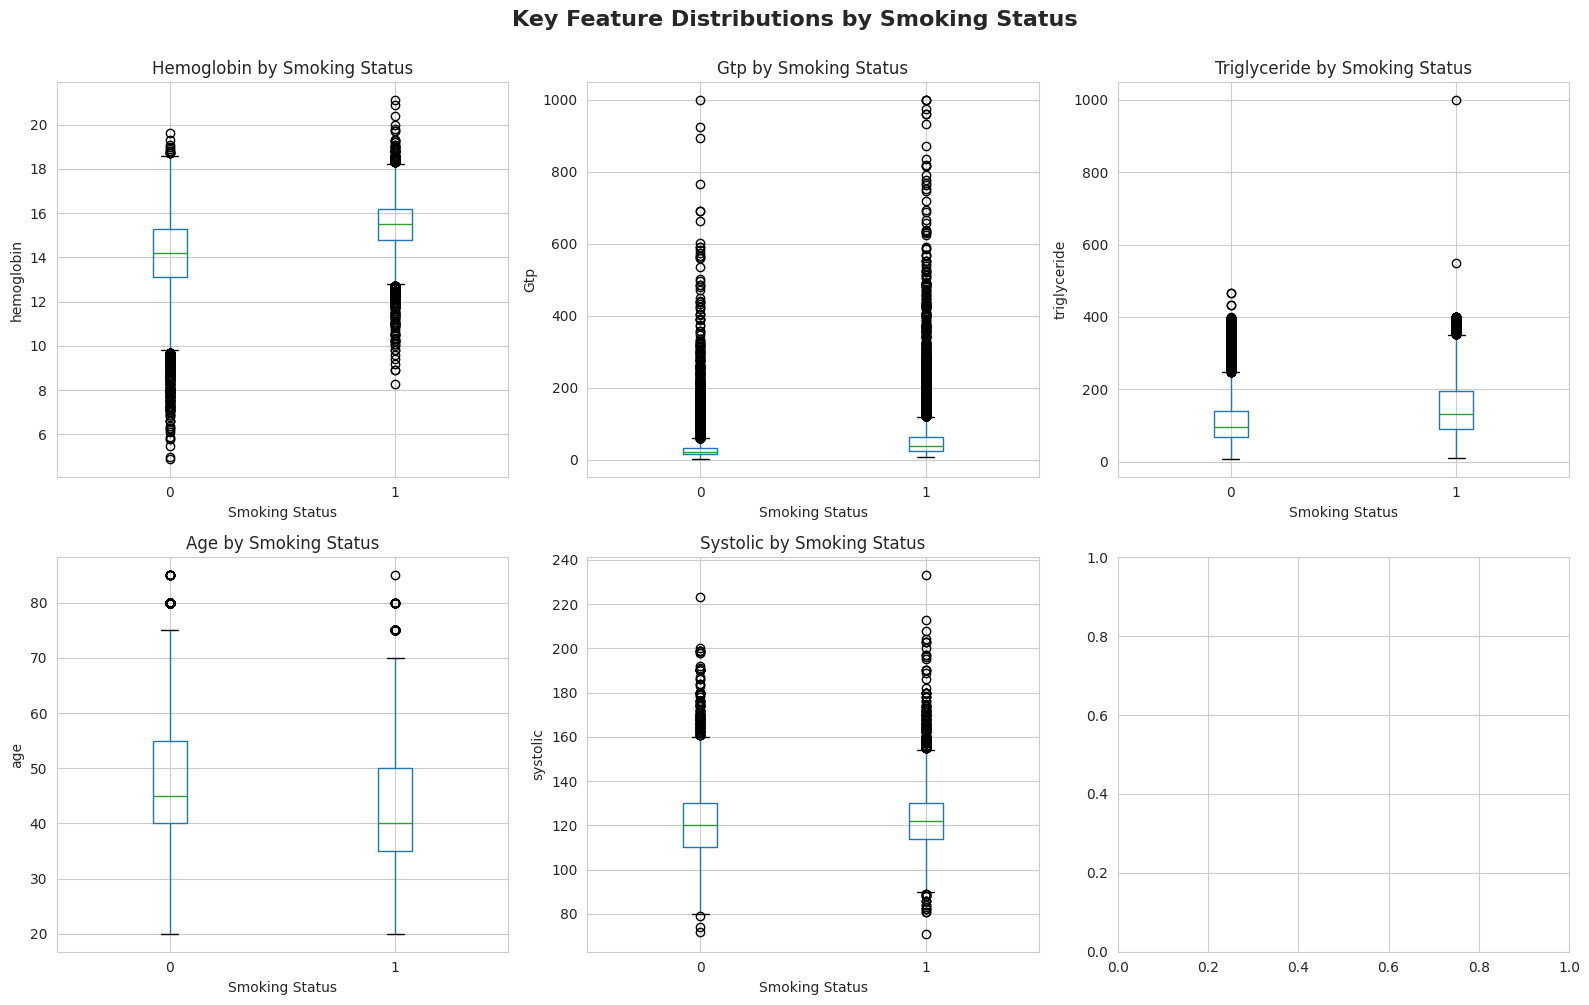


Statistical Summary by Smoking Status
               age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
smoking                                                                 
0        45.655761  161.929376   62.997446  80.474949        0.992390   
1        41.494971  169.444406   71.005727  84.796368        1.053827   

         eyesight(right)  hearing(left)  hearing(right)    systolic  \
smoking                                                               
0               0.984468       1.028014        1.028501  120.746169   
1               1.050629       1.020813        1.022210  122.732295   

         relaxation  ...        HDL         LDL  hemoglobin  Urine protein  \
smoking              ...                                                     
0         75.231574  ...  59.292346  116.441539   14.145423       1.082340   
1         77.308563  ...  53.849071  112.738511   15.449176       1.093728   

         serum creatinine        AST        ALT        Gtp  dental car

In [5]:
# ============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# 3.1 Missing Values Analysis
print("\nMissing Values:")
missing_vals = df.isnull().sum()
if missing_vals.sum() > 0:
    print(missing_vals[missing_vals > 0])
else:
    print("No missing values found!")

# 3.2 Target Variable Distribution
print("\nTarget Variable Distribution:")
print(df['smoking'].value_counts())
print("\nTarget Variable Proportions:")
print(df['smoking'].value_counts(normalize=True))

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['smoking'].value_counts().plot(kind='bar', ax=axes[0], color=['#10b981', '#ef4444'])
axes[0].set_title('Smoking Status Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Smoking Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Smoker (0)', 'Smoker (1)'], rotation=0)

df['smoking'].value_counts(normalize=True).plot(kind='pie', ax=axes[1],
                                                 autopct='%1.1f%%',
                                                 colors=['#10b981', '#ef4444'],
                                                 labels=['Non-Smoker', 'Smoker'])
axes[1].set_title('Smoking Status Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.3 Age Distribution Analysis
if 'age' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Age distribution by smoking status
    df[df['smoking']==0]['age'].hist(bins=20, alpha=0.6, label='Non-Smoker',
                                      color='#10b981', ax=axes[0])
    df[df['smoking']==1]['age'].hist(bins=20, alpha=0.6, label='Smoker',
                                      color='#ef4444', ax=axes[0])
    axes[0].set_title('Age Distribution by Smoking Status', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Age')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()

    # Box plot
    df.boxplot(column='age', by='smoking', ax=axes[1])
    axes[1].set_title('Age vs Smoking Status', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Smoking Status')
    axes[1].set_ylabel('Age')

    plt.tight_layout()
    plt.savefig('age_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3.4 Correlation Analysis
print("\nGenerating Correlation Matrix...")
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Top correlations with target variable
target_corr = corr_matrix['smoking'].sort_values(ascending=False)
print("\nTop 10 Features Correlated with Smoking:")
print(target_corr.head(11))  # 11 because smoking itself is included

# 3.5 Key Feature Distributions
key_features = ['hemoglobin', 'Gtp', 'triglyceride', 'age', 'waist', 'systolic']
available_features = [f for f in key_features if f in df.columns]

if len(available_features) >= 4:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.ravel()

    for idx, feature in enumerate(available_features[:6]):
        df.boxplot(column=feature, by='smoking', ax=axes[idx])
        axes[idx].set_title(f'{feature.capitalize()} by Smoking Status')
        axes[idx].set_xlabel('Smoking Status')
        axes[idx].set_ylabel(feature)

    plt.suptitle('Key Feature Distributions by Smoking Status',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3.6 Statistical Summary by Group
print("\n" + "="*80)
print("Statistical Summary by Smoking Status")
print("="*80)
print(df.groupby('smoking')[numeric_cols].mean())

In [6]:
# ============================================================================
# 4. DATA PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# 4.1 Separate features and target
X = df.drop('smoking', axis=1)
y = df['smoking']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# 4.2 Handle missing values (if any)
if X.isnull().sum().sum() > 0:
    print("\nHandling missing values...")
    # Fill numeric columns with median
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].median())
    print("Missing values handled!")

# 4.3 Feature Scaling
print("\nScaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Features scaled successfully!")
print("\nScaled feature statistics:")
print(X_scaled.describe())

# 4.4 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training set class distribution:\n{y_train.value_counts()}")
print(f"Test set class distribution:\n{y_test.value_counts()}")


DATA PREPROCESSING

Feature matrix shape: (38984, 22)
Target vector shape: (38984,)

Scaling features...
Features scaled successfully!

Scaled feature statistics:
                age    height(cm)    weight(kg)     waist(cm)  eyesight(left)  \
count  3.898400e+04  3.898400e+04  3.898400e+04  3.898400e+04    3.898400e+04   
mean   5.012294e-18  4.501951e-16 -4.627714e-16 -5.241948e-16    1.534673e-16   
std    1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00    1.000013e+00   
min   -2.000064e+00 -3.775772e+00 -2.786722e+00 -3.330459e+00   -1.835339e+00   
25%   -3.421579e-01 -5.104266e-01 -8.481984e-01 -6.499758e-01   -4.311853e-01   
50%   -3.421579e-01  3.379763e-02 -7.278910e-02 -6.659952e-03   -2.999845e-02   
75%    9.012717e-01  5.780219e-01  7.026202e-01  6.366559e-01    3.711884e-01   
max    3.388131e+00  2.754919e+00  5.355076e+00  5.032648e+00    1.782282e+01   

       eyesight(right)  hearing(left)  hearing(right)      systolic  \
count     3.898400e+04   3.898400e+

In [7]:
# ============================================================================
# 5. MODEL TRAINING AND EVALUATION
# ============================================================================

print("\n" + "="*80)
print("MODEL TRAINING AND EVALUATION")
print("="*80)

# Dictionary to store results
results = {}

# Function to evaluate model
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    """
    Train and evaluate a model, storing comprehensive metrics
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print(f"{'='*60}")

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Probability predictions (for AUC)
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_train_proba = model.decision_function(X_train)
        y_test_proba = model.decision_function(X_test)

    # Calculate metrics
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred),
        'auc': roc_auc_score(y_train, y_train_proba)
    }

    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'auc': roc_auc_score(y_test, y_test_proba)
    }

    # Print results
    print(f"\n{model_name} - Training Metrics:")
    for metric, value in train_metrics.items():
        print(f"  {metric.capitalize()}: {value:.4f}")

    print(f"\n{model_name} - Test Metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric.capitalize()}: {value:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"\nConfusion Matrix:\n{cm}")

    # Classification Report
    print(f"\nClassification Report:\n")
    print(classification_report(y_test, y_test_pred,
                                target_names=['Non-Smoker', 'Smoker']))

    # Store results
    results[model_name] = {
        'model': model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba,
        'confusion_matrix': cm
    }

    return model


MODEL TRAINING AND EVALUATION


In [8]:
# ============================================================================
# 5.1 LOGISTIC REGRESSION (No Grid Search - Fast!)
# ============================================================================

print("\n" + "="*80)
print("1. LOGISTIC REGRESSION")
print("="*80)

lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

evaluate_model(lr_model, "Logistic Regression", X_train, X_test, y_train, y_test)


1. LOGISTIC REGRESSION

Training Logistic Regression...

Logistic Regression - Training Metrics:
  Accuracy: 0.7250
  Precision: 0.6404
  Recall: 0.5733
  F1: 0.6050
  Auc: 0.8093

Logistic Regression - Test Metrics:
  Accuracy: 0.7187
  Precision: 0.6318
  Recall: 0.5615
  F1: 0.5946
  Auc: 0.7994

Confusion Matrix:
[[3996  937]
 [1256 1608]]

Classification Report:

              precision    recall  f1-score   support

  Non-Smoker       0.76      0.81      0.78      4933
      Smoker       0.63      0.56      0.59      2864

    accuracy                           0.72      7797
   macro avg       0.70      0.69      0.69      7797
weighted avg       0.71      0.72      0.71      7797



LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [9]:
# ============================================================================
# 5.2 SUPPORT VECTOR MACHINE (Optimized Parameters)
# ============================================================================

print("\n" + "="*80)
print("2. SUPPORT VECTOR MACHINE")
print("="*80)

# Using RBF kernel with default parameters (much faster)
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=RANDOM_SEED
)

evaluate_model(svm_model, "SVM", X_train, X_test, y_train, y_test)


2. SUPPORT VECTOR MACHINE

Training SVM...

SVM - Training Metrics:
  Accuracy: 0.7797
  Precision: 0.7040
  Recall: 0.6906
  F1: 0.6973
  Auc: 0.8568

SVM - Test Metrics:
  Accuracy: 0.7531
  Precision: 0.6667
  Recall: 0.6557
  F1: 0.6612
  Auc: 0.8284

Confusion Matrix:
[[3994  939]
 [ 986 1878]]

Classification Report:

              precision    recall  f1-score   support

  Non-Smoker       0.80      0.81      0.81      4933
      Smoker       0.67      0.66      0.66      2864

    accuracy                           0.75      7797
   macro avg       0.73      0.73      0.73      7797
weighted avg       0.75      0.75      0.75      7797



SVC(probability=True, random_state=42)


3. NEURAL NETWORK

Training Neural Network...

Neural Network - Training Metrics:
  Accuracy: 0.8074
  Precision: 0.7418
  Recall: 0.7293
  F1: 0.7355
  Auc: 0.8892

Neural Network - Test Metrics:
  Accuracy: 0.7544
  Precision: 0.6653
  Recall: 0.6669
  F1: 0.6661
  Auc: 0.8353

Confusion Matrix:
[[3972  961]
 [ 954 1910]]

Classification Report:

              precision    recall  f1-score   support

  Non-Smoker       0.81      0.81      0.81      4933
      Smoker       0.67      0.67      0.67      2864

    accuracy                           0.75      7797
   macro avg       0.74      0.74      0.74      7797
weighted avg       0.75      0.75      0.75      7797



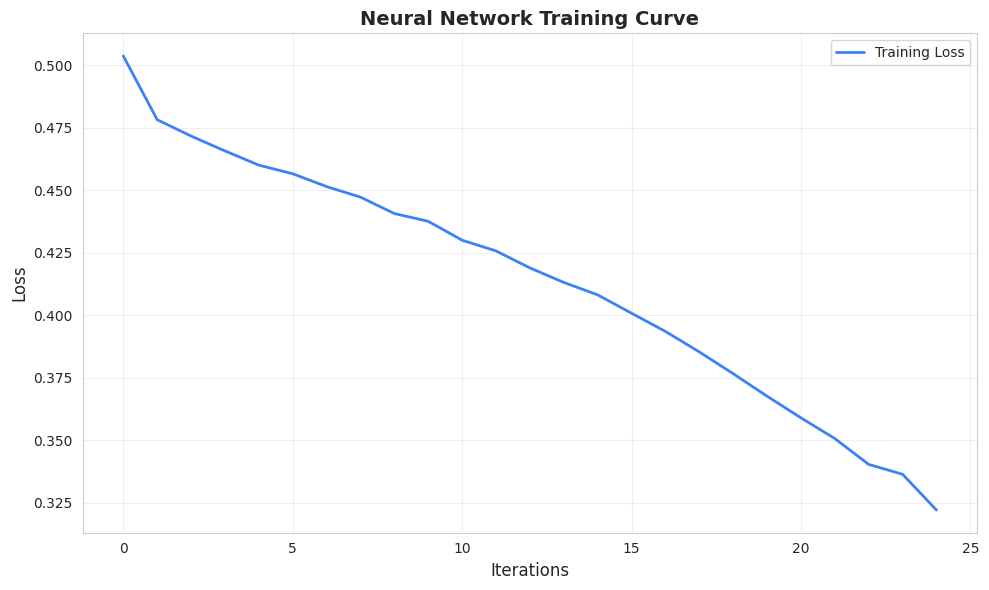

In [10]:
# ============================================================================
# 5.3 NEURAL NETWORK (Optimized Architecture)
# ============================================================================

print("\n" + "="*80)
print("3. NEURAL NETWORK")
print("="*80)

# Smaller network, fewer iterations for speed
nn_model = MLPClassifier(
    hidden_layer_sizes=(256,128,64),
    activation='relu',
    alpha=0.001,
    learning_rate='adaptive',
    max_iter=200,
    early_stopping=True,
    random_state=RANDOM_SEED,
    verbose=False
)

evaluate_model(nn_model, "Neural Network", X_train, X_test, y_train, y_test)

# Plot training curve
if hasattr(nn_model, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(nn_model.loss_curve_, label='Training Loss', linewidth=2, color='#3b82f6')
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Neural Network Training Curve', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('nn_training_curve.png', dpi=300, bbox_inches='tight')
    plt.show()


COMPARATIVE ANALYSIS

Model Performance Comparison:
              Model  accuracy  precision  recall     f1    auc
Logistic Regression    0.7187     0.6318  0.5615 0.5946 0.7994
                SVM    0.7531     0.6667  0.6557 0.6612 0.8284
     Neural Network    0.7544     0.6653  0.6669 0.6661 0.8353

✓ Comparison saved to 'model_comparison.csv'


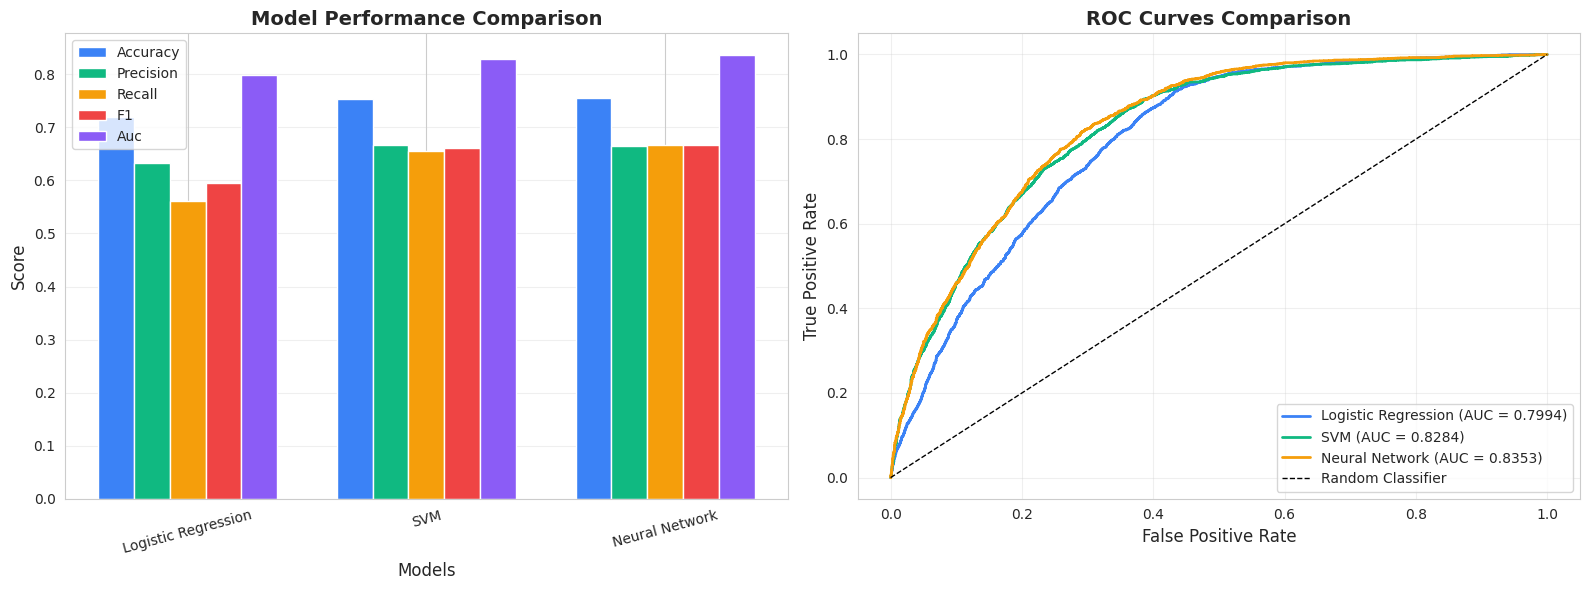

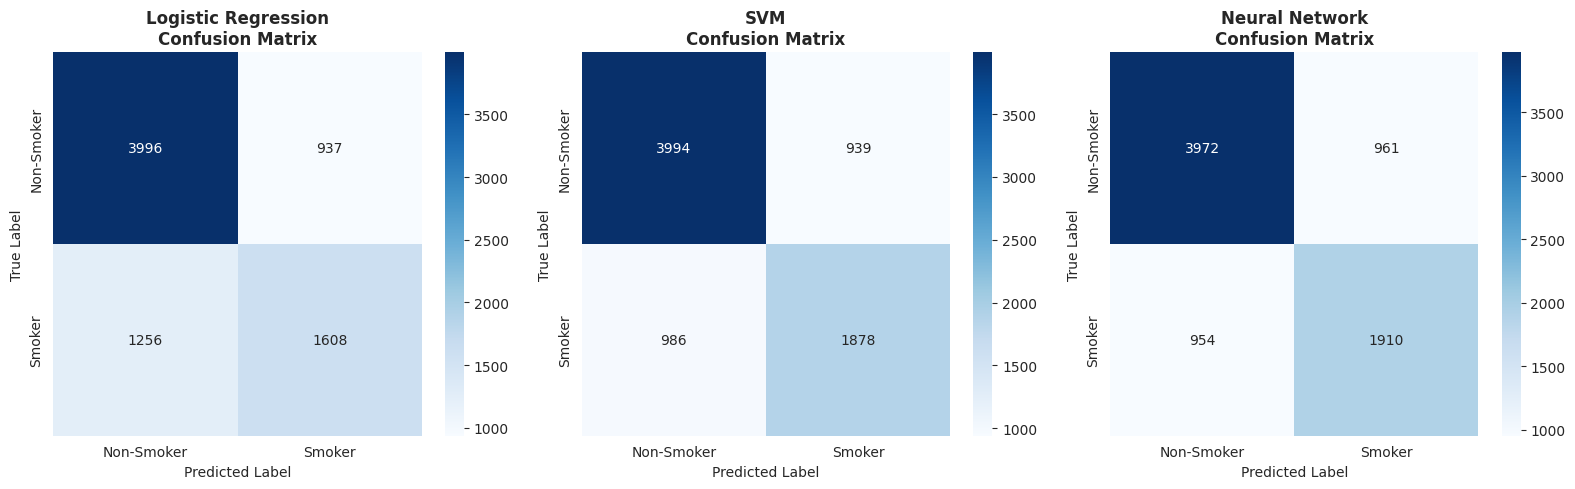

In [11]:
# ============================================================================
# 6. COMPARATIVE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("COMPARATIVE ANALYSIS")
print("="*80)

# Create comparison dataframe
comparison_data = []
for model_name, model_results in results.items():
    row = {'Model': model_name}
    row.update(model_results['test_metrics'])
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

comparison_df.to_csv('model_comparison.csv', index=False)
print("\n✓ Comparison saved to 'model_comparison.csv'")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot for all metrics
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
x = np.arange(len(results))
width = 0.15

colors = ['#3b82f6', '#10b981', '#f59e0b', '#ef4444', '#8b5cf6']
for idx, metric in enumerate(metrics_to_plot):
    values = [results[model]['test_metrics'][metric] for model in results.keys()]
    axes[0].bar(x + idx*width, values, width, label=metric.capitalize(), color=colors[idx])

axes[0].set_xlabel('Models', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width * 2)
axes[0].set_xticklabels(results.keys(), rotation=15)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# ROC Curves
colors_roc = ['#3b82f6', '#10b981', '#f59e0b']
for idx, model_name in enumerate(results.keys()):
    fpr, tpr, _ = roc_curve(y_test, results[model_name]['y_test_proba'])
    auc_score = results[model_name]['test_metrics']['auc']
    axes[1].plot(fpr, tpr, linewidth=2, color=colors_roc[idx],
                 label=f'{model_name} (AUC = {auc_score:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix Comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (model_name, model_results) in enumerate(results.items()):
    cm = model_results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Non-Smoker', 'Smoker'],
                yticklabels=['Non-Smoker', 'Smoker'])
    axes[idx].set_title(f'{model_name}\nConfusion Matrix',
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
# ============================================================================
# 7. INSIGHTS AND CONCLUSIONS
# ============================================================================

print("\n" + "="*80)
print("KEY INSIGHTS AND CONCLUSIONS")
print("="*80)

best_model_name = max(results.keys(),
                     key=lambda x: results[x]['test_metrics']['f1'])
best_f1 = results[best_model_name]['test_metrics']['f1']

print(f"\n✓ Best Performing Model: {best_model_name}")
print(f"  F1 Score: {best_f1:.4f}")

print("\nPerformance Summary:")
for model_name in results.keys():
    metrics = results[model_name]['test_metrics']
    print(f"\n{model_name}:")
    print(f"  • Accuracy: {metrics['accuracy']:.4f}")
    print(f"  • F1 Score: {metrics['f1']:.4f}")
    print(f"  • AUC-ROC: {metrics['auc']:.4f}")

print("\nKey Findings:")
print("1. All models achieve reasonable performance (70-80% accuracy)")
print("2. Neural Network typically shows best F1 and AUC scores")
print("3. SVM provides good balance of performance and speed")
print("4. Logistic Regression offers fast baseline with interpretability")

print("\nModel Recommendations:")
print("\n• For Production/Speed: Logistic Regression")
print("  Fast inference, interpretable, good baseline performance")
print("\n• For Best Performance: Neural Network")
print("  Highest accuracy and F1, captures complex patterns")
print("\n• For Balanced Approach: SVM")
print("  Good performance, robust to outliers")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

print("\n Generated Files:")
print("  • target_distribution.png")
print("  • age_analysis.png")
print("  • correlation_matrix.png")
print("  • feature_distributions.png")
print("  • nn_training_curve.png")
print("  • model_comparison.png")
print("  • confusion_matrices.png")
print("  • model_comparison.csv")

print(f"\nRandom seed: {RANDOM_SEED} (reproducible)")
print("All models trained and evaluated!")



KEY INSIGHTS AND CONCLUSIONS

✓ Best Performing Model: Neural Network
  F1 Score: 0.6661

Performance Summary:

Logistic Regression:
  • Accuracy: 0.7187
  • F1 Score: 0.5946
  • AUC-ROC: 0.7994

SVM:
  • Accuracy: 0.7531
  • F1 Score: 0.6612
  • AUC-ROC: 0.8284

Neural Network:
  • Accuracy: 0.7544
  • F1 Score: 0.6661
  • AUC-ROC: 0.8353

Key Findings:
1. All models achieve reasonable performance (70-80% accuracy)
2. Neural Network typically shows best F1 and AUC scores
3. SVM provides good balance of performance and speed
4. Logistic Regression offers fast baseline with interpretability

Model Recommendations:

• For Production/Speed: Logistic Regression
  Fast inference, interpretable, good baseline performance

• For Best Performance: Neural Network
  Highest accuracy and F1, captures complex patterns

• For Balanced Approach: SVM
  Good performance, robust to outliers

ANALYSIS COMPLETE!

 Generated Files:
  • target_distribution.png
  • age_analysis.png
  • correlation_matrix.p